In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Titanic-Dataset.csv to Titanic-Dataset.csv


Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing Values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin    

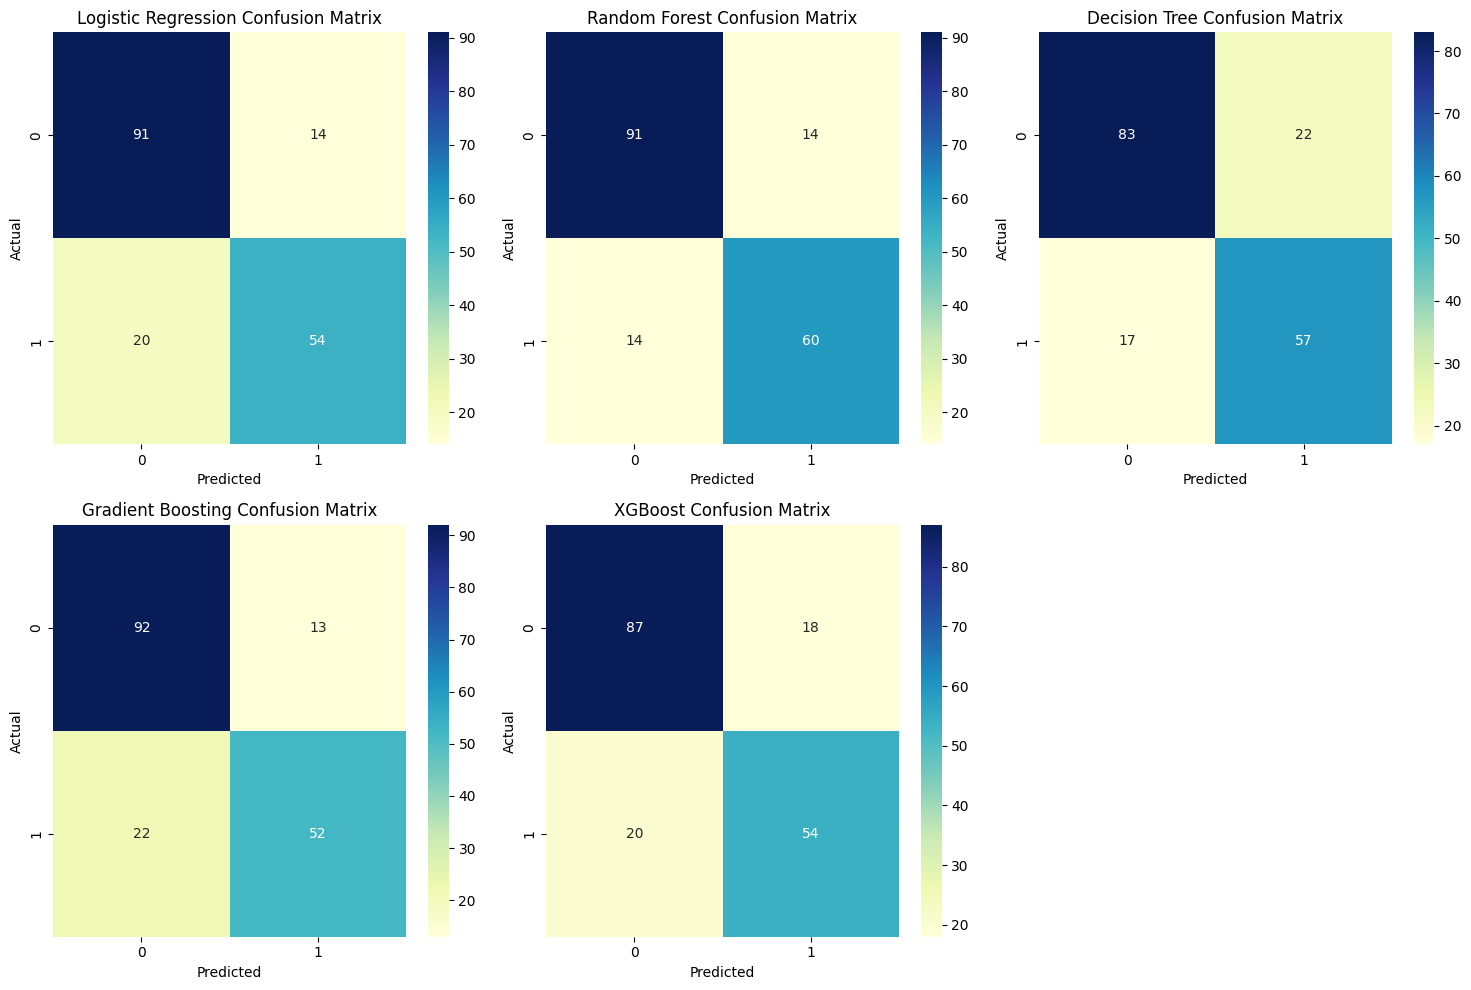

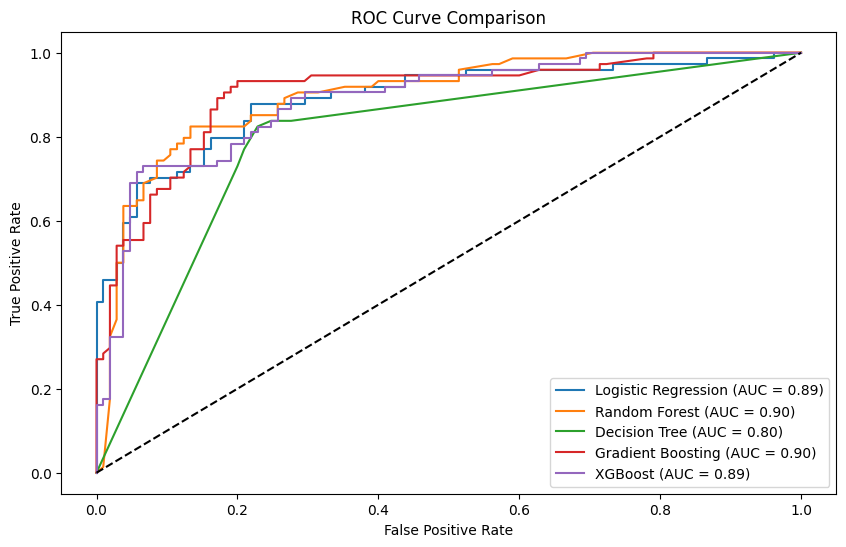

In [ ]:
# 🚢 Titanic Survival Prediction

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Step 2: Load Dataset
df = pd.read_csv('Titanic-Dataset.csv')
print("Initial Dataset Info:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

# Step 3: Fill Missing Values
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

# Step 4: Feature Engineering
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = np.where(df['FamilySize'] == 1, 1, 0)

# Extract titles from names
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace(['Mme', 'Lady', 'Countess'], 'Mrs')
df['Title'] = df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev', 'Jonkheer', 'Don', 'Sir'], 'Rare')

# Step 5: Encode Categorical Variables
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])
df['Title'] = le.fit_transform(df['Title'])

# Step 6: Drop Irrelevant Columns
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True, errors='ignore')

# Step 7: Train-Test Split
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Train and Evaluate Multiple Models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))

# Step 10: Confusion Matrices
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models.items()):
    preds = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, preds)
    plt.subplot(2, 3, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Step 11: ROC Curves
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()
